In [1]:
%load_ext autoreload
%autoreload 2

# Hybrid Vertical Federated Neural Networks

In [ ]:
import torch.nn as nn
class HybridSplitBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.deeper_conv = nn.Sequential(
            #nn.AdaptiveMaxPool2d(1)
            nn.AdaptiveAvgPool2d(1)  # [B, 128, 1, 1]
        )

        self.project = nn.Sequential(
            nn.Linear(64, 49)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.deeper_conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.project(x) 
        return x
    


class LocalHybridSplitClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(49, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):  
        return self.classifier(x)


class GlobalHybridSplitClassifierHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(4*49, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x_concat):
        return self.classifier(x_concat)
        

In [10]:
import torch
from collections.abc import Iterable
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset as TorchDataset
import os 


from federated_inference.common.environment import Member
from federated_inference.configs.data_config import DataConfiguration
from federated_inference.configs.model_configs import  HybridSplitModelConfiguration


class HybridSplitClient():

    def __init__(self, 
            idx, 
            seed: int,
            data_config: DataConfiguration,
            model_config: HybridSplitModelConfiguration,
            dataset: TorchDataset,
            labels,
            log: bool = True, 
            log_interval: int = 100, 
            save_interval: int = 10
        ):
        self.idx = idx
        self.seed = seed
        self.data = dataset
        self.data_config = data_config
        self.model_config = model_config
        self.device = model_config.DEVICE
        self.labels = labels
        self.numerical_labels = range(len(labels))
        self.member_type = Member.CLIENT
        self.model = None
        self.log = log
        self.log_interval = log_interval
        self.save_interval = save_interval
        self.base_model = model_config.CLIENT_BASE_MODEL().to(self.device)
        self.classifier_model = model_config.CLIENT_CLASSIFIER_MODEL().to(self.device)

    def select_subset(self, ids: Iterable[int], set_type: str = "train"):
        if set_type == "test":
            return Subset(self.data.test_dataset, ids)
        else: 
            return Subset(self.data.train_dataset, ids)

    def send_all(self):
        return self.data.train_dataset

    def request_pred(self, idx: int|None = None, set_type: str = "test", pred_all: bool= False, keep_label: bool = False): 
        if idx != None:
            if set_type == "test":
                return self.data.test_dataset[idx] if keep_label else self.data.test_dataset[idx][0] 
        elif pred_all:
            return self.data.test_dataset if keep_label else [img for img, label in self.data.test_dataset]

    def check(self, predicted_labels, pred_all: bool = True):
        if pred_all:
            true_labels = self.data.test_dataset.targets
            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels, average='macro')
            recall = recall_score(true_labels, predicted_labels, average='macro')
            f1 = f1_score(true_labels, predicted_labels, average='macro') 

            print("\n=== Metrics ===")
            print(f"Accuracy : {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall   : {recall:.4f}")
            print(f"F1 Score : {f1:.4f}") 

            cm = confusion_matrix(true_labels, predicted_labels, labels=self.numerical_labels)
            self.cm = pd.DataFrame(cm, index=[f'True {l}' for l in self.labels],
                                    columns=[f'Pred {l}' for l in self.labels])
            self.accuracy = accuracy
            self.precision = precision
            self.recall = recall
            self.f1 = f1 


    def load(self):
        result_path = f"./results/hybrid/{self.model_config.version}/{self.data_config.DATASET_NAME}/{self.seed}"
        client_result_path = os.path.join(result_path, "clients") 

        # Base
        model_path = os.path.join(client_result_path, f'model_client_base_{self.idx}.pth').replace("\\", "/")
        network_state_dict = torch.load(model_path)
        self.base = self.base_model.load_state_dict(network_state_dict)

        # Classifier Head
        model_path = os.path.join(client_result_path, f'model_client_classifier_{self.idx}.pth').replace("\\", "/")
        network_state_dict = torch.load(model_path)
        self.classifier_model.load_state_dict(network_state_dict)
#

    def to_loader(self, testdata):
        self.testloader = DataLoader(self.data.test_dataset, batch_size=self.model_config.BATCH_SIZE_TEST, shuffle=False) 

            


In [ ]:
import os
from collections import defaultdict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

from federated_inference.common.environment import Member
from federated_inference.common.early_stopper import EarlyStopper

class HybridSplitServer():

    def __init__(self, 
            idx: int, 
            seed: int,
            model_config,
            data_config,
            log: bool = True, 
            log_interval: int = 100,
            save_interval: int = 20
        ):
        self.idx = idx
        self.seed = seed
        self.version = model_config.version
        self.model_config = model_config
        self.data_config = data_config
        self.seed = seed
        self.number_of_clients = 4
        self.n_epoch = model_config.N_EPOCH
        self.device = model_config.DEVICE
        self.member_type = Member.SERVER
        self.server_model = model_config.SERVER_MODEL().to(self.device)
        self.client_base_models = [model_config.CLIENT_BASE_MODEL().to(self.device) for c in range(self.number_of_clients)]
        self.client_classifier_models = [model_config.CLIENT_CLASSIFIER_MODEL().to(self.device) for c in range(self.number_of_clients)]
        self.CRITERION = nn.CrossEntropyLoss()
        self.CRITERION_NAME = "CrossEntropyLoss"
        self.weight_decay = 0
        self.SERVER_OPTIMIZER = optim.Adam(self.server_model.parameters() , lr=model_config.LEARNING_RATE, weight_decay=self.weight_decay)
        self.CLIENT_BASE_OPTIMIZERS =  [optim.Adam(self.client_base_models[c].parameters() , lr=model_config.LEARNING_RATE, weight_decay=self.weight_decay ) for c in range(self.number_of_clients)]
        self.CLIENT_CLASSIFIER_OPTIMIZERS =  [optim.Adam(self.client_classifier_models[c].parameters() , lr=model_config.LEARNING_RATE, weight_decay=self.weight_decay) for c in range(self.number_of_clients)]
        self.OPTIMIZER_NAME = "Adam"
        self.LOCAL_CLASSIFIER_CRITERION = nn.CrossEntropyLoss()

        self.log = log
        self.log_interval = log_interval
        self.save_interval = save_interval

        if self.log: 
            self.train_losses = []
            self.test_losses = []
            self.accuracies = []


    def _to_loader(self, trainsets, testsets, batch_size_train, batch_size_val, batch_size_test, train_shuffle, val_shuffle, test_shuffle, train_ratio):
        # TODO refactoing to use self
        if True:
            dataset_length = len(trainsets[0])
            assert all(len(trainset) == dataset_length for trainset in trainsets), "All trainsets must be the same length"

            indices = np.arange(dataset_length)
            self.train_set_indices = np.arange(dataset_length)

            np.random.shuffle(indices)

            train_end = round(train_ratio * dataset_length)
            
            
            self.train_indices = indices[:train_end]
            val_indices = indices[train_end:]

            traindatas = [Subset(trainset, self.train_indices) for trainset in trainsets]
            valdatas = [Subset(trainset, val_indices) for trainset in trainsets]
        else:
            traindatas = [Subset(trainset, range(round(train_ratio*len(trainset)))) for trainset in trainsets]
            valdatas = [Subset(trainset, range(round(train_ratio*len(trainset)), len(trainset))) for trainset in trainsets]
        self.trainloader = [DataLoader(traindata, batch_size=batch_size_train, shuffle=False)  for traindata in traindatas]
        self.valloader = [DataLoader(valdata, batch_size=batch_size_val, shuffle=False) for valdata in valdatas]
        self.testloader = [DataLoader(testdata, batch_size=batch_size_test, shuffle=False) for testdata in testsets]

    def shuffle_loader(self, trainsets, batch_size_train, batch_size_val, train_ratio):
        # TODO refactoing to use self
        if True:
            dataset_length = len(trainsets[0])
            assert all(len(trainset) == dataset_length for trainset in trainsets), "All trainsets must be the same length"

            np.random.shuffle(self.train_set_indices)

            train_end = round(train_ratio * dataset_length)
            train_indices = self.train_set_indices[:train_end]
            val_indices = self.train_set_indices[train_end:]

            traindatas = [Subset(trainset, train_indices) for trainset in trainsets]
            valdatas = [Subset(trainset, val_indices) for trainset in trainsets]
        else:
            traindatas = [Subset(trainset, range(round(train_ratio*len(trainset)))) for trainset in trainsets]
            valdatas = [Subset(trainset, range(round(train_ratio*len(trainset)), len(trainset))) for trainset in trainsets]
        self.trainloader = [DataLoader(traindata, batch_size=batch_size_train, shuffle=False)  for traindata in traindatas]
        self.valloader = [DataLoader(valdata, batch_size=batch_size_val, shuffle=False) for valdata in valdatas]


    def _pred_loader(self, testsets, batch_size_test, test_shuffle):
        return  [DataLoader(testdata, batch_size=batch_size_test, shuffle=False) for testdata in testsets]
        
    
    def train(self, epoch):
        for batch_idx, batches in enumerate(zip(*self.trainloader)):
            data_slices = [batch[0].to(self.device).float() for batch in batches]
            target = batches[0][1].to(self.device).long()
    
            # ====== Base forward passes ======
            client_activations = []
            classifier_grads_per_client = []
            classifier_losses = []
            classifier_preds = []
    
            for data, base_model, classifier_model, optimizer in zip(data_slices, self.client_base_models,  self.client_classifier_models, self.CLIENT_CLASSIFIER_OPTIMIZERS):
                base_model.train()
                activation = base_model(data)
                activation.requires_grad_()
                client_activations.append(activation)
                classifier_model.train()
                optimizer.zero_grad()
                classifier_output = classifier_model(activation)
                classifier_pred = classifier_output.argmax(dim=1)
                loss = self.LOCAL_CLASSIFIER_CRITERION(classifier_output, target)
                classifier_losses.append(loss.item())
    
                grads = torch.autograd.grad(loss, [activation] + list(classifier_model.parameters()), retain_graph=True)
                classifier_grads_per_client.append(grads[0])
    
                for param, grad in zip(classifier_model.parameters(), grads[1:]):
                    param.grad = grad
                optimizer.step()
    
                classifier_preds.append(classifier_pred)
            concat_activations = torch.cat(client_activations, dim=1)
    
            # ====== Server forward and backprop======
            self.server_model.train()
            self.SERVER_OPTIMIZER.zero_grad()
            server_output = self.server_model(concat_activations)
            server_loss = self.CRITERION(server_output, target)
            server_pred = server_output.argmax(dim=1)
            server_grads = torch.autograd.grad(server_loss, [concat_activations] + list(self.server_model.parameters()), retain_graph=True)
            #Server Backprop
            server_concat_activation_grad = server_grads[0]
            server_model_grads = server_grads[1:]
            
            # Apply gradients manually to model parameters
            for param, grad in zip(self.server_model.parameters(), server_model_grads):
                param.grad = grad  # Set .grad for optimizer
    
            self.SERVER_OPTIMIZER.step()
    

            # ====== Base Backprop combined gradients ======
            activation_sizes = [act.shape[1] for act in client_activations]
            activation_grads_server = torch.split(server_concat_activation_grad, activation_sizes, dim=1)
    
            for i, (base_model, optimizer, data) in enumerate(zip(self.client_base_models, self.CLIENT_BASE_OPTIMIZERS, data_slices)):
                optimizer.zero_grad()
    
                # Combine gradients: server + classifier
                combined_grad = activation_grads_server[i] + classifier_grads_per_client[i] 
    
                # Backward through base
                activation = base_model(data)
                activation.backward(combined_grad)
                optimizer.step()
            
            if batch_idx % self.log_interval == 0:
                print(f"Epoch {epoch} | Batch {batch_idx} | Server Loss: {server_loss.item():.4f} | "
                      f"Classifier Losses: {[round(x, 4) for x in classifier_losses]}")

    def validate(self):
        self.server_model.eval()
        
        val_loss = 0
        with torch.no_grad():
            for batch_idx, batches in enumerate(zip(*self.valloader)):
                # batches is tuple of batch from each loader
                data_slices = [batch[0].to(self.device).float() for batch in batches]
                target = batches[0][1].to(self.device).long()
                client_activations = []
                client_val_loss = 0
                for data, client_base_model, classifier_model in zip(data_slices, self.client_base_models, self.client_classifier_models):
                    #Client FeedForward
                    client_base_model.eval()
                    activation = client_base_model(data)
                    client_activations.append(activation)
                    classifier_output = classifier_model(activation)
                    client_loss = self.LOCAL_CLASSIFIER_CRITERION(classifier_output, target).item()
                    client_val_loss += client_loss
                client_val_loss /= self.number_of_clients
                concat_activations = torch.cat(client_activations, dim=1)
                #Server FeedForward
                self.server_model.eval()
                output = self.server_model(concat_activations)
                val_loss +=  self.CRITERION(output, target).item()

        val_loss /= len(self.valloader[0].dataset)

        if self.early_stopper.best_loss is None or val_loss < self.early_stopper.best_loss:
            print("Validation loss improved. Saving model...")
            self.save()
        self.early_stopper(val_loss)

    def test(self):
        self.server_model.eval()
        
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for batch_idx, batches in enumerate(zip(*self.testloader)):
                # batches is tuple of batch from each loader
                data_slices = [batch[0].to(self.device).float() for batch in batches]
                target = batches[0][1].to(self.device).long()
                client_activations = []
                for data, client_base_model in zip(data_slices, self.client_base_models):
                    #Client FeedForward
                    client_base_model.eval()
                    activation = client_base_model(data)
                    client_activations.append(activation)
                concat_activations = torch.cat(client_activations, dim=1)
                #Server FeedForward
                self.server_model.eval()
                output = self.server_model(concat_activations)
                test_loss +=  self.CRITERION(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(self.testloader[0].dataset)
        accuracy = 100. * correct / len(self.testloader[0].dataset)
        if self.log: 
            self.test_losses.append(test_loss)
            self.accuracies.append(accuracy)
        print(f'\nTest set: Average loss per Sample: {test_loss:.4f}, Accuracy: {correct}/{len(self.testloader[0].dataset)} '
            f'({accuracy:.0f}%)\n')
            
        
    def test_inferences(self):
        self.server_model.eval()
        clients_preds = {i: [] for i in range(self.number_of_clients)}
        test_loss = 0
        server_preds = []

        with torch.no_grad():
            for batch_idx, batches in enumerate(zip(*self.testloaders)):
                # batches is tuple of batch from each loader
                data_slices = [batch[0].to(self.device).float() for batch in batches]
                target = batches[0][1].to(self.device).long()
                client_activations = []
                for i, (data, client_base_model, classifier_model) in enumerate(zip(data_slices, self.client_base_models, self.client_classifier_models)):
                    #Client FeedForward
                    client_base_model.eval()
                    classifier_model.eval()
                    activation = client_base_model(data)
                    client_class_logits = classifier_model(activation)
                    clients_preds[i] += client_class_logits.argmax(dim=1, keepdim=True).squeeze().tolist()
                    client_activations.append(activation)
                    
                concat_activations = torch.cat(client_activations, dim=1)
                #Server FeedForward
                self.server_model.eval()
                output = self.server_model(concat_activations)
                test_loss +=  self.CRITERION(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                server_preds += pred.squeeze().tolist()

        return clients_preds, server_preds
            
    def run_training(self, trainset, testset):
        self.server_early_stopper = EarlyStopper()
        self.early_stopper = EarlyStopper()
        self._to_loader(trainset, testset, 
            self.model_config.BATCH_SIZE_TRAIN,
            self.model_config.BATCH_SIZE_VAL, 
            self.model_config.BATCH_SIZE_TEST, 
            self.model_config.TRAIN_SHUFFLE,
            self.model_config.VAL_SHUFFLE, 
            self.model_config.TEST_SHUFFLE,
            self.model_config.TRAIN_RATIO)
        self.test()
        
        self.classifier_test()
        for epoch in range(1, self.model_config.N_EPOCH + 1):
            self.train(epoch)
            self.test()
            self.classifier_test()
            self.validate()
            
            if self.early_stopper.early_stop:
                self.early_stop_epoch = epoch
                print("early_stop_triggered")
                break
            self.shuffle_loader(trainset, 
            self.model_config.BATCH_SIZE_TRAIN,
            self.model_config.BATCH_SIZE_VAL, 
            self.model_config.TRAIN_RATIO)
        
        print("loading best model to server...")
        self.load()

    
    def run_infernces(self, testsets): 
        self.testloaders = [DataLoader(testdata, batch_size=self.model_config.BATCH_SIZE_TEST, shuffle=False) for testdata in testsets]
        clients_preds, server_preds = self.test_inferences()

        return clients_preds, server_preds
        
    def pred(self, testset,  pred=True):
        predictions = []
        loader = self._pred_loader(testset, self.model_config.BATCH_SIZE_TEST, self.model_config.TEST_SHUFFLE)
        with torch.no_grad():
            for batch_idx, batches in enumerate(zip(*loader)):
                # batches is tuple of batch from each loader
                data_slices = [batch[0].to(self.device).float() for batch in batches]
                target = batches[0][1].to(self.device).long()
                client_activations = []
                for data, client_base_model in zip(data_slices, self.client_base_models):
                    #Client FeedForward
                    client_base_model.eval()
                    activation = client_base_model(data)
                    client_activations.append(activation)
                concat_activations = torch.cat(client_activations, dim=1)
                #Server FeedForward
                self.server_model.eval()
                output = self.server_model(concat_activations)
                pred = output.argmax(dim=1, keepdim=True)
                predictions = predictions + pred.squeeze().tolist()
        return predictions

    def save(self):
        result_path = f"./results/hybrid/{self.model_config.version}/{self.data_config.DATASET_NAME}/{self.seed}"
        os.makedirs(result_path, exist_ok=True)
        model_path = os.path.join(result_path, f'model_server_{self.idx}.pth').replace("\\", "/")
        optimizer_path = os.path.join(result_path, f'optimizer_server_{self.idx}.pth').replace("\\", "/")
        torch.save(self.server_model.state_dict(), model_path)
        torch.save(self.SERVER_OPTIMIZER.state_dict(), optimizer_path)

        client_result_path =os.path.join(result_path, "clients")
        os.makedirs(client_result_path, exist_ok=True)
        for i, client_base_model in enumerate(self.client_base_models): 
            model_path = os.path.join(client_result_path, f'model_client_base_{i}.pth').replace("\\", "/")
            optimizer_path = os.path.join(client_result_path, f'optimizer_client_base_{i}.pth').replace("\\", "/")
            torch.save(client_base_model.state_dict(), model_path)
            torch.save(self.CLIENT_BASE_OPTIMIZERS[i].state_dict(), optimizer_path)
                    
        for i, client_classifier_model in enumerate(self.client_classifier_models): 
            model_path = os.path.join(client_result_path, f'model_client_classifier_{i}.pth').replace("\\", "/")
            optimizer_path = os.path.join(client_result_path, f'optimizer_classifier_client_{i}.pth').replace("\\", "/")
            torch.save(client_classifier_model.state_dict(), model_path)
            torch.save(self.CLIENT_CLASSIFIER_OPTIMIZERS[i].state_dict(), optimizer_path)
        
    def load(self):
        result_path = f"./results/hybrid/{self.model_config.version}/{self.data_config.DATASET_NAME}/{self.seed}"
        model_path = os.path.join(result_path, f'model_server_{self.idx}.pth').replace("\\", "/")
        optimizer_path = os.path.join(result_path, f'optimizer_server_{self.idx}.pth').replace("\\", "/")
        network_state_dict = torch.load(model_path)
        self.server_model.load_state_dict(network_state_dict)
        optimizer_state_dict = torch.load(optimizer_path)
        self.SERVER_OPTIMIZER.load_state_dict(optimizer_state_dict)

        client_result_path = os.path.join(result_path, "clients")
        for i, (client_base_model, model_optimizer) in enumerate(zip(self.client_base_models, self.CLIENT_BASE_OPTIMIZERS)): 
            model_path = os.path.join(client_result_path, f'model_client_base_{i}.pth').replace("\\", "/")
            optimizer_path = os.path.join(client_result_path, f'optimizer_client_base_{i}.pth').replace("\\", "/")
            network_state_dict = torch.load(model_path)
            client_base_model.load_state_dict(network_state_dict)
            optimizer_state_dict = torch.load(optimizer_path)
            model_optimizer.load_state_dict(optimizer_state_dict)
        
        for i, (client_classifier_model, model_optimizer) in enumerate(zip(self.client_classifier_models, self.CLIENT_CLASSIFIER_OPTIMIZERS)): 
            model_path = os.path.join(client_result_path, f'model_client_classifier_{i}.pth').replace("\\", "/")
            optimizer_path = os.path.join(client_result_path, f'optimizer_classifier_client_{i}.pth').replace("\\", "/")
            network_state_dict = torch.load(model_path)
            client_classifier_model.load_state_dict(network_state_dict)
            optimizer_state_dict = torch.load(optimizer_path)
            model_optimizer.load_state_dict(optimizer_state_dict)

                   
                            
    def classifier_test(self):
        test_loss_values = [0 for c in self.client_base_models]
        correct_values = [0 for c in self.client_base_models]
        with torch.no_grad():
            for batch_idx, batches in enumerate(zip(*self.testloader)):
                data_slices = [batch[0].to(self.device).float() for batch in batches]
                target = batches[0][1].to(self.device).long()
                for client_idx, client in enumerate(zip(data_slices, self.client_base_models, self.client_classifier_models)):
                    data, client_base_model, classifier_model = client 
                    client_base_model.eval()
                    classifier_model.eval()
                    activation = client_base_model(data)
                    classifier_output = classifier_model(activation)
                    test_loss_values[client_idx] +=  self.LOCAL_CLASSIFIER_CRITERION(classifier_output, target).item()
                    pred = classifier_output.argmax(dim=1, keepdim=True)
                    correct_values[client_idx]+= pred.eq(target.view_as(pred)).sum().item()
        test_loss_values = [t/ len(self.testloader[0].dataset) for t in test_loss_values]
        accuracy_values = [100. * c / len(self.testloader[0].dataset) for c in correct_values]

        if self.log: 
            self.test_losses.append(test_loss_values)
            self.accuracies.append(accuracy_values)
        print(f'\nTest set: Average loss per Sample: {test_loss_values}, Accuracy: {correct_values}/{len(self.testloader[0].dataset)}'
            f'({accuracy_values}%)\n')


                

In [12]:
            
from federated_inference.common.environment import  DataMode, TransformType
from federated_inference.configs.model_configs import HybridVFLWoRouterModelConfiguration
from federated_inference.simulations.simulation import Simulation
from federated_inference.simulations.utils import *

class HybridSplitSimulation(Simulation): 
    def __init__(self, seed, version, data_config, transform_config, server_model, client_base_model, client_classifier_model, transform_type: TransformType = TransformType.FULL_STRIDE_PARTITION, exist=False):
        self.seed = seed
        self.data_config = data_config
        self.transform_config = transform_config
        self.server_model_config =  HybridVFLWoRouterModelConfiguration(version, server_model, client_base_model, client_classifier_model)
        self.data_mode = DataMode.VERTICAL
        self.transform_type = transform_type
        self.dataset =  self.load_data(data_config)
        self.client_datasets, self.transformation = self.transform_data(self.dataset, data_mode = self.data_mode, transform_config = transform_config, transform_type = self.transform_type)
        self.clients = [HybridSplitClient(idx, seed, data_config, self.server_model_config, dataset, data_config.LABELS) for idx, dataset in enumerate(self.client_datasets)]
        self.server = HybridSplitServer(0, seed, self.server_model_config , self.data_config)

    def train(self): 
        datasets = [client.send_all() for client in self.clients]
        testsets = [client.request_pred(pred_all = True, keep_label = True) for client in self.clients]
        self.server.run_training(datasets, testsets)

    def test_inference(self):
        testsets = [client.request_pred(pred_all = True, keep_label = True) for client in self.clients]
        predictions = self.server.pred(testsets)
        self.clients[0].check(predictions)

In [14]:
from federated_inference.common.utils import set_seed
from federated_inference.configs.data_config import DataConfiguration
from federated_inference.configs.transform_config import DataTransformConfiguration

DATASET = 'MNIST'
VERSION = "hybrid_wo_router_v1"
for seed in [4]:
    set_seed(seed)
    data_config = DataConfiguration(DATASET)
    transform_config = DataTransformConfiguration()
    simulation2 = HybridSplitSimulation(seed, VERSION,  data_config, transform_config, GlobalHybridSplitClassifierHead, HybridSplitBase, LocalHybridSplitClassifierHead)
    simulation2.train()

MNIST training data loaded.
MNIST test data loaded.

Test set: Average loss per Sample: 0.0362, Accuracy: 1327/10000 (13%)


Test set: Average loss per Sample: [0.036146217918396, 0.03614617111682892, 0.036166108417510986, 0.036185809755325316], Accuracy: [1028, 1135, 1010, 1010]/10000([10.28, 11.35, 10.1, 10.1]%)

Epoch 1 | Batch 0 | Server Loss: 2.4625 | Classifier Losses: [2.4107, 2.4103, 2.4235, 2.5071]
Epoch 1 | Batch 100 | Server Loss: 0.1976 | Classifier Losses: [1.0592, 0.8775, 1.0187, 1.1039]
Epoch 1 | Batch 200 | Server Loss: 0.1362 | Classifier Losses: [1.0058, 0.8088, 0.7607, 1.2128]
Epoch 1 | Batch 300 | Server Loss: 0.1888 | Classifier Losses: [1.2131, 0.8384, 0.8045, 0.9768]
Epoch 1 | Batch 400 | Server Loss: 0.0758 | Classifier Losses: [0.8404, 0.6219, 0.9676, 0.8837]
Epoch 1 | Batch 500 | Server Loss: 0.1291 | Classifier Losses: [1.0472, 0.7902, 0.7493, 1.0545]
Epoch 1 | Batch 600 | Server Loss: 0.2153 | Classifier Losses: [1.1443, 0.8018, 0.747, 0.8607]
Epoch 1 | Batc

KeyboardInterrupt: 

# Visualization

2025-10-19 11:01:38,932 - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.79607844].


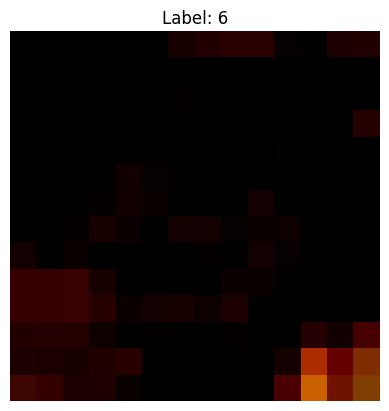

In [ ]:
import matplotlib.pyplot as plt

# Assuming you're using PyTorch and simulation is already defined
image, label = simulation.dataset.train_dataset[0]
image = simulation.client_datasets[0].train_dataset.dataset[0][0][0].evidence

# If the image is a tensor, convert it to numpy
if hasattr(image, 'numpy'):
    image = image.numpy()

# If the image has shape [C, H, W], convert it to [H, W, C]
if image.ndim == 3 and image.shape[0] in [1, 3]:
    image = image.transpose(1, 2, 0)

# Plot the image
plt.imshow(image, cmap='gray' if image.ndim == 2 or image.shape[2] == 1 else None)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()